In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def imshow(img: cv2.Mat):
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    plt.show()

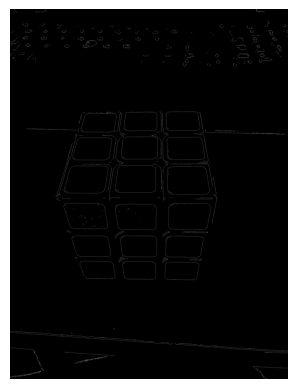

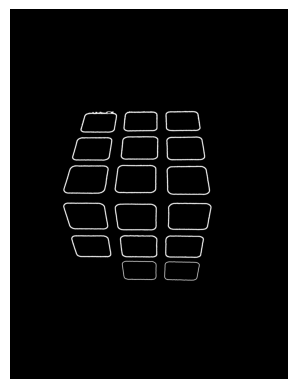

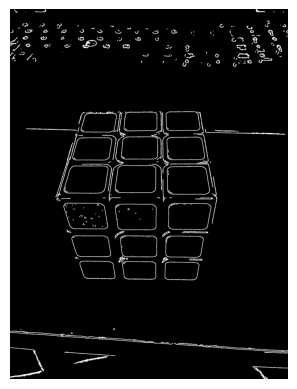

In [16]:
img = cv2.imread("./cube_less_ugly.png")
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(img, (21, 21), 5)
# thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 1)
thresh = cv2.Canny(blur, 20, 30)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
adjusted = cv2.dilate(thresh, kernel)
# adjusted = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, kernel)
contours = sorted(cv2.findContours(adjusted, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0], key=cv2.contourArea, reverse=True)
approx = [*map(lambda x: cv2.approxPolyDP(x, 0.03*cv2.arcLength(x, True), True), contours)]
imshow(thresh)
imshow(cv2.drawContours(np.zeros_like(img), contours[:32], -1, (255, 255, 255), 5))
imshow(adjusted)